# Exercise 1

## Imports

In [112]:
import os.path as path
import pandas as pd
import gzip
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from io import SEEK_CUR
from typing import List

## Prepare the data

In [113]:
high_energy_dataset = 'ca-HepPh.txt.gz'
facebook_dataset = 'facebook_combined.txt.gz'
pathways_dataset = 'PP-Pathways_ppi.csv.gz'
data_folder = 'data'

chosen_dataset = pathways_dataset

In [114]:
def load_dataset(dataset: str, data_folder: str = data_folder) -> pd.DataFrame:
    pt = path.join(data_folder, dataset)
    
    if dataset == 'ca-HepPh.txt.gz':
        with gzip.open(pt, 'rb') as f:
            c = f.read(1)
            while c == b'#':
                f.readline()
                c = f.read(1)
            f.seek(-1, SEEK_CUR)
            return pd.read_csv(f, sep='\t', header=None)
        
    elif dataset == 'facebook_combined.txt.gz':
        return pd.read_csv(pt, sep=' ', header=None)

    return pd.read_csv(pt, header=None)

In [115]:
dataset = load_dataset(chosen_dataset).rename(columns={0: 'source', 1: 'target'})

In [116]:
# Obtained by manual analysis of the first few eigenvectors
# TODO: find appropriate values for the other datasets
dataset_n_clusters = {
    high_energy_dataset: 15,
    facebook_dataset: 6,
    pathways_dataset: ...,
}

dataset_n_components = {
    high_energy_dataset: 20,
    facebook_dataset: 8,
    pathways_dataset: ...,
}

n_clusters = dataset_n_clusters[chosen_dataset]
n_components = dataset_n_components[chosen_dataset]

## Our implementation

### Create the Laplacian matrix

All graphs are treated as undirected graphs.

In [117]:
graph = nx.from_pandas_edgelist(dataset, source='source', target='target', create_using=nx.Graph)

if chosen_dataset == high_energy_dataset:
    remove = [node for node,degree in dict(graph.degree()).items() if degree < 3]
    graph.remove_nodes_from(remove)

laplacian_matrix = nx.laplacian_matrix(graph).todense()

### Decomposition (find eigenvalues and eigenvectors of L)

In [118]:
from scipy.sparse.linalg import eigs

In [119]:
n_components = 15

In [120]:
eigenvalues, eigenvectors = eigs(laplacian_matrix.astype(np.float32), k=n_components, which='SR')
# eigenvalues, eigenvectors = np.linalg.eig(laplacian_matrix)

KeyboardInterrupt: 

In [ ]:
np.sort(eigenvalues)

array([-3.37620659e-05+0.j, -8.70733493e-06+0.j, -8.22926995e-06+0.j,
       -4.98010240e-06+0.j, -2.25026042e-06+0.j,  7.71290445e-07+0.j,
        8.89690364e-06+0.j,  1.10812925e-05+0.j,  2.87564326e-05+0.j,
        3.55327092e-02+0.j,  5.87068200e-02+0.j,  7.66519606e-02+0.j,
        9.17298868e-02+0.j,  9.71073657e-02+0.j,  9.83903408e-02+0.j,
        1.24270603e-01+0.j,  1.35205045e-01+0.j,  1.36400595e-01+0.j,
        1.40921175e-01+0.j,  1.45180985e-01+0.j], dtype=complex64)

In [ ]:
eigenvalues.shape

(20,)

/home/pedro/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'Eigenvalue')

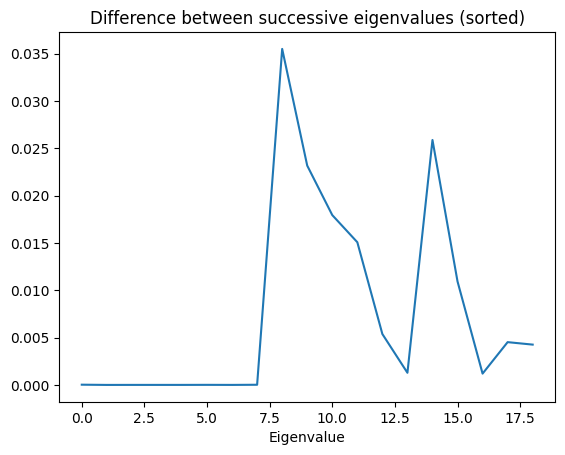

In [ ]:
differences = np.ediff1d(np.sort(eigenvalues))

plt.plot(differences[:40])
plt.title('Difference between successive eigenvalues (sorted)')
plt.xlabel('Eigenvalue')

### Clustering

Create the features matrix from the first N eigenvectors.

In [110]:
from sklearn.cluster import KMeans

clustering = KMeans(n_clusters=n_clusters).fit(eigenvectors.real)

/home/pedro/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


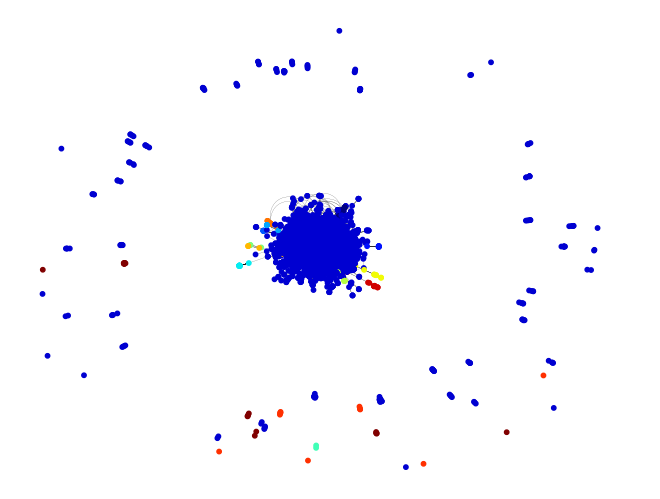

In [111]:
plot_clustering(graph,clustering.labels_)

## Scikit-learn Spectral Clustering

In [ ]:
from sklearn.cluster import SpectralClustering

clustering = SpectralClustering(
    n_clusters=n_clusters,
    n_components=n_clusters,
    affinity='precomputed',
    assign_labels='kmeans',
    random_state=0
    ).fit(nx.adjacency_matrix(graph).todense())

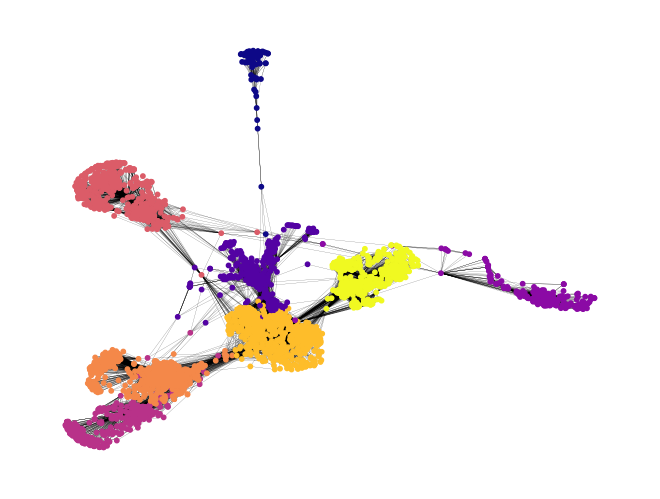

In [ ]:
plot_clustering(graph, clustering_labels)

## Spark Power Iteration Clustering

In [ ]:
from pyspark.ml.clustering import PowerIterationClustering
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

spark = SparkSession.builder \
    .appName('SpectralClustering') \
    .config('spark.master', 'local[*]') \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/24 14:41:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
dataset_spark = spark.createDataFrame(dataset)

Add the weight column (all at 1s).

In [ ]:
dataset_spark = dataset_spark.withColumn('weight', F.lit(1))

In [ ]:
pic = PowerIterationClustering(k=n_clusters, maxIter=20, initMode="degree", srcCol='source', dstCol='target', weightCol="weight")
dataset_clustered = pic.assignClusters(dataset_spark).toPandas()

23/05/24 14:41:47 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


## Visualization

In [ ]:
def plot_clustering(graph: nx.Graph, clustering_labels: List[int]):
    nx.draw(graph, node_color=clustering_labels, node_size=10, width = 0.1, cmap=plt.cm.jet)

In [ ]:
#plot_clustering(graph, clustering_labels)